In [1]:
using OrdinaryDiffEq, SteadyStateDiffEq, ModelingToolkit, QuantumOptics, DifferentialEquations
using Plots

In [2]:
include("../../src/indexing.jl")
include("../../src/doubleSums.jl")
include("../../src/averageSums.jl")
include("../../src/indexedMeanfield.jl")
include("../../src/indexedScale.jl")
include("../../src/indexedCorrelation.jl")

filterComplete_corr (generic function with 1 method)

In [3]:
order = 2 #order of the cumulant expansion
@cnumbers N Δ g κ Γ R ν

extraIndices=[:q]

# Hilbertspace
hc = FockSpace(:cavity)
ha = NLevelSpace(:atom,2)

h = hc ⊗ ha

# Indices and Operators
ind(i) = Index(h,Symbol(i),N,true)
@qnumbers a::Destroy(h)
σ(i,j,k) = IndexedOperator(Transition(h,:σ,i,j),k)

σ (generic function with 1 method)

In [4]:
# Define the Hamiltonian
H = -Δ*a'a + g*(IndexedSingleSum(a'*σ(1,2,ind(:i)),ind(:i)) + IndexedSingleSum(a*σ(2,1,ind(:i)),ind(:i)))

(Σ(i=1:N)g*(a′*σ12i)+Σ(i=1:N)g*(a*σ21i)+-Δ*(a′*a))

In [5]:
# Define Jump-Operators with corresponding rates
J = [a,σ(1,2,ind(:l)),σ(2,1,ind(:l)),σ(2,2,ind(:l))]
rates = [κ, Γ, R, ν]

# Define Operators, for which the meanfield shall be calculated
ops = [a'*a,σ(2,2,ind(:k))]

# It is best-practice to use every Index-Entity in only one context

# create Meanfield-Equations with given order for the given operators
eqs = indexedMeanfield(ops,H,J;rates=rates,order=order)

∂ₜ(⟨a′*a⟩) = (0 + 1im)*var"∑(i=1:N)g*⟨a*σ21i⟩" + (0 - 1im)*var"∑(i=1:N)g*⟨a′*σ12i⟩" - κ*⟨a′*a⟩
∂ₜ(⟨σ22k⟩) = R + (0 + 1im)*g*⟨a′*σ12k⟩ + (0 - 1im)*g*⟨a*σ21k⟩ - R*⟨σ22k⟩ - Γ*⟨σ22k⟩


In [6]:
ops_test = [a'*a]

1-element Vector{QMul{Nothing}}:
 (a′*a)

In [7]:
eqs_test = indexedMeanfield(ops_test,H,J;rates=rates,order=order)

∂ₜ(⟨a′*a⟩) = (0 + 1im)*var"∑(i=1:N)g*⟨a*σ21i⟩" + (0 - 1im)*var"∑(i=1:N)g*⟨a′*σ12i⟩" - κ*⟨a′*a⟩


In [8]:
# custom filter function
# Using the filter function defined below, one can reduce the size of the complete system to only contain phase-invariant terms
φ(x::Average) = φ(x.arguments[1])
φ(::Destroy) = -1
φ(::Create) =1
φ(x::QTerm) = sum(map(φ, x.args_nc))
φ(x::Transition) = x.i - x.j
φ(x::IndexedOperator) = x.op.i - x.op.j
φ(x::IndexedSingleSum) = φ(x.term)
φ(x::SymbolicUtils.Sym{Parameter, IndexedAverageSum}) = φ(x.metadata.term)
φ(x::SymbolicUtils.Sym{Parameter, SpecialIndexedAverage}) = φ(x.metadata.term)
φ(x::SpecialIndexedAverage) = φ(x.term)
phase_invariant(x) = iszero(φ(x))

phase_invariant (generic function with 1 method)

In [9]:
test_c = indexedComplete(eqs_test;filter_func=phase_invariant,scaling=false,extraIndices=[:q,:r]);

In [10]:
eqs_c = indexedComplete(eqs;filter_func=phase_invariant,scaling=false,extraIndices=extraIndices); #scaling still needs some adaptions -> still too many equations/states on lhs

In [11]:
# Now one can easily scale the Equations above
# This is done, considering, that each and every expectation value with the same operators in it have the same value
eqs_sc = scaleME(eqs_c);

In [12]:
eqs_c

∂ₜ(⟨a′*a⟩) = (0 + 1im)*var"∑(i=1:N)g*⟨a*σ21i⟩" + (0 - 1im)*var"∑(i=1:N)g*⟨a′*σ12i⟩" - κ*⟨a′*a⟩
∂ₜ(⟨σ22k⟩) = R + (0 + 1im)*g*⟨a′*σ12k⟩ + (0 - 1im)*g*⟨a*σ21k⟩ - R*⟨σ22k⟩ - Γ*⟨σ22k⟩
∂ₜ(⟨a′*σ12k⟩) = (0 + 1im)*var"∑(i=1:N)(i≠k)g*⟨σ21i*σ12k⟩" + (0 + 1im)*g*⟨σ22k⟩ + (0 - 1im)*g*⟨a′*a⟩ + (0 - 1im)*Δ*⟨a′*σ12k⟩ + (0 + 2im)*g*⟨σ22k⟩*⟨a′*a⟩ - 0.5R*⟨a′*σ12k⟩ - 0.5Γ*⟨a′*σ12k⟩ - 0.5κ*⟨a′*σ12k⟩ - 0.5ν*⟨a′*σ12k⟩
∂ₜ(⟨σ12k*σ21q⟩) = (0.0 + 1.0im)*g*⟨a′*σ12k⟩ + (0.0 - 1.0im)*g*⟨a*σ21q⟩ + (0.0 - 2.0im)*g*⟨σ22q⟩*⟨a′*σ12k⟩ + (0.0 + 2.0im)*g*⟨σ22k⟩*⟨a*σ21q⟩ - R*⟨σ12k*σ21q⟩ - Γ*⟨σ12k*σ21q⟩ - ν*⟨σ12k*σ21q⟩


In [13]:
eqs_sc

∂ₜ(⟨a′*a⟩) = (0 - 1im)*N*g*⟨a′*σ121⟩ + (0 + 1im)*N*g*⟨a*σ211⟩ - κ*⟨a′*a⟩
∂ₜ(⟨σ221⟩) = R + (0 + 1im)*g*⟨a′*σ121⟩ + (0 - 1im)*g*⟨a*σ211⟩ - R*⟨σ221⟩ - Γ*⟨σ221⟩
∂ₜ(⟨a′*σ121⟩) = (0 + 1im)*g*⟨σ221⟩ + (0 - 1im)*g*⟨a′*a⟩ + (0 - 1im)*Δ*⟨a′*σ121⟩ + (0 + 2im)*g*⟨σ221⟩*⟨a′*a⟩ + (0 + 1im)*g*(N - 1)*⟨σ211*σ122⟩ - 0.5R*⟨a′*σ121⟩ - 0.5Γ*⟨a′*σ121⟩ - 0.5κ*⟨a′*σ121⟩ - 0.5ν*⟨a′*σ121⟩
∂ₜ(⟨σ121*σ212⟩) = (0.0 + 1.0im)*g*⟨a′*σ121⟩ + (0.0 - 1.0im)*g*⟨a*σ211⟩ + (0.0 - 2.0im)*g*⟨σ221⟩*⟨a′*σ121⟩ + (0.0 + 2.0im)*g*⟨σ221⟩*⟨a*σ211⟩ - R*⟨σ121*σ212⟩ - Γ*⟨σ121*σ212⟩ - ν*⟨σ121*σ212⟩


In [14]:
# For the final equations, a eleminiation for redundant averages is still needed (for now)
eqs_final = substReds(eqs_sc;scaling=true)

∂ₜ(⟨a′*a⟩) = (0 - 1im)*N*g*⟨a′*σ121⟩ + (0 + 1im)*N*g*⟨⟨a′*σ121⟩⟩ - κ*⟨a′*a⟩
∂ₜ(⟨σ221⟩) = R + (0 + 1im)*g*⟨a′*σ121⟩ + (0 - 1im)*g*⟨⟨a′*σ121⟩⟩ - R*⟨σ221⟩ - Γ*⟨σ221⟩
∂ₜ(⟨a′*σ121⟩) = (0 + 1im)*g*⟨σ221⟩ + (0 - 1im)*g*⟨a′*a⟩ + (0 - 1im)*Δ*⟨a′*σ121⟩ + (0 + 2im)*g*⟨σ221⟩*⟨a′*a⟩ + (0 + 1im)*g*(N - 1)*⟨σ121*σ212⟩ - 0.5R*⟨a′*σ121⟩ - 0.5Γ*⟨a′*σ121⟩ - 0.5κ*⟨a′*σ121⟩ - 0.5ν*⟨a′*σ121⟩
∂ₜ(⟨σ121*σ212⟩) = (0.0 + 1.0im)*g*⟨a′*σ121⟩ + (0.0 - 1.0im)*g*⟨⟨a′*σ121⟩⟩ + (0.0 - 2.0im)*g*⟨σ221⟩*⟨a′*σ121⟩ + (0.0 + 2.0im)*g*⟨σ221⟩*⟨⟨a′*σ121⟩⟩ - R*⟨σ121*σ212⟩ - Γ*⟨σ121*σ212⟩ - ν*⟨σ121*σ212⟩


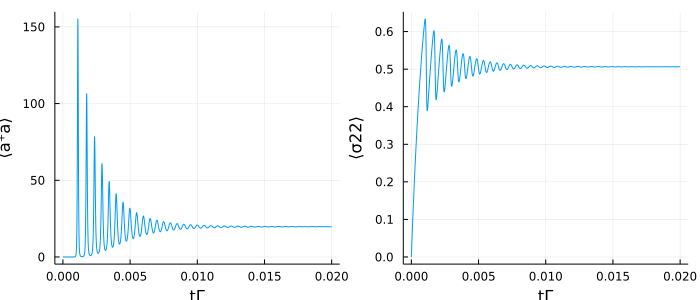

In [15]:
# define the ODE System and Problem
@named sys = ODESystem(eqs_final)

# Initial state
u0 = zeros(ComplexF64, length(eqs_final))
# System parameters
N_ = 2e5
Γ_ = 1.0 #Γ=1mHz
Δ_ = 2500Γ_ #Δ=2.5Hz
g_ = 1000Γ_ #g=1Hz
κ_ = 5e6*Γ_ #κ=5kHz
R_ = 1000Γ_ #R=1Hz
ν_ = 1000Γ_ #ν=1Hz

ps = [N, Δ, g, κ, Γ, R, ν]
p0 = [N_, Δ_, g_, κ_, Γ_, R_, ν_]

prob = ODEProblem(sys,u0,(0.0, 1.0/50Γ_), ps.=>p0)

# Solve the Problem
sol = solve(prob,maxiters=1e7) #,Tsit5()

# Plot time evolution
t = sol.t
n = real.(sol[a'a])
s22 = real.(sol[NumberedOperator(Transition(h,:σ,2,2),1)])
# Plot
p1 = plot(t, n, xlabel="tΓ", ylabel="⟨a⁺a⟩", legend=false)
p2 = plot(t, s22, xlabel="tΓ", ylabel="⟨σ22⟩", legend=false)
plot(p1, p2, layout=(1,2), size=(700,300))

In [16]:
# For the Spectrum 
corr = indexedCorrelationFunction(a', a, eqs_c; steady_state=true, filter_func=phase_invariant,extraIndices=[:q,:r],scaling=true);

In [17]:
corr.de

∂ₜ(⟨a′*a_0⟩) = (0 - 1im)*Δ*⟨a′*a_0⟩ + (0 + 1im)*N*g*⟨a_0*σ211⟩ - 0.5κ*⟨a′*a_0⟩
∂ₜ(⟨a_0*σ211⟩) = (0 + 1im)*g*⟨a′*a_0⟩ + (0 - 2im)*g*⟨σ221⟩*⟨a′*a_0⟩ - 0.5R*⟨a_0*σ211⟩ - 0.5Γ*⟨a_0*σ211⟩ - 0.5ν*⟨a_0*σ211⟩


In [18]:
S = Spectrum(corr, ps);

In [19]:
prob_ss = SteadyStateProblem(prob)
sol_ss = solve(prob_ss, DynamicSS(Tsit5(); abstol=1e-8, reltol=1e-8),
    reltol=1e-14, abstol=1e-14, maxiters=5e7);

In [20]:
ω = [-10:0.01:10;]Γ_
spec = S(ω,sol_ss.u,p0)
spec_n = spec ./ maximum(spec)
δ = abs(ω[(findmax(spec)[2])]);

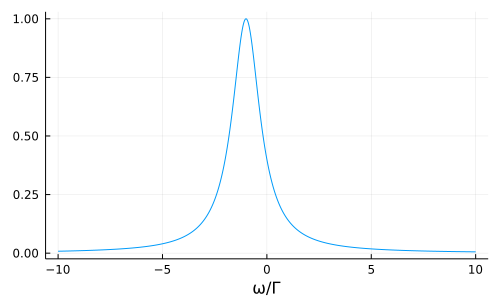

In [21]:
plot(ω, spec_n, xlabel="ω/Γ", legend=false, size=(500,300))